<a href="https://colab.research.google.com/github/Shelly10-10/flood_prediction/blob/main/Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

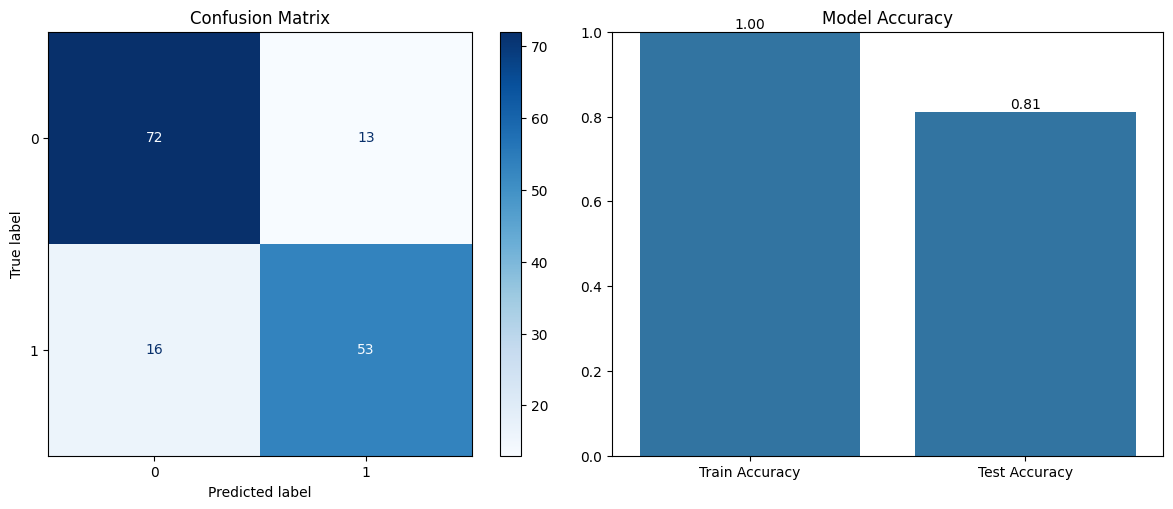

/tmp/ipython-input-2-2365598301.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=X.columns[indices], palette="viridis")


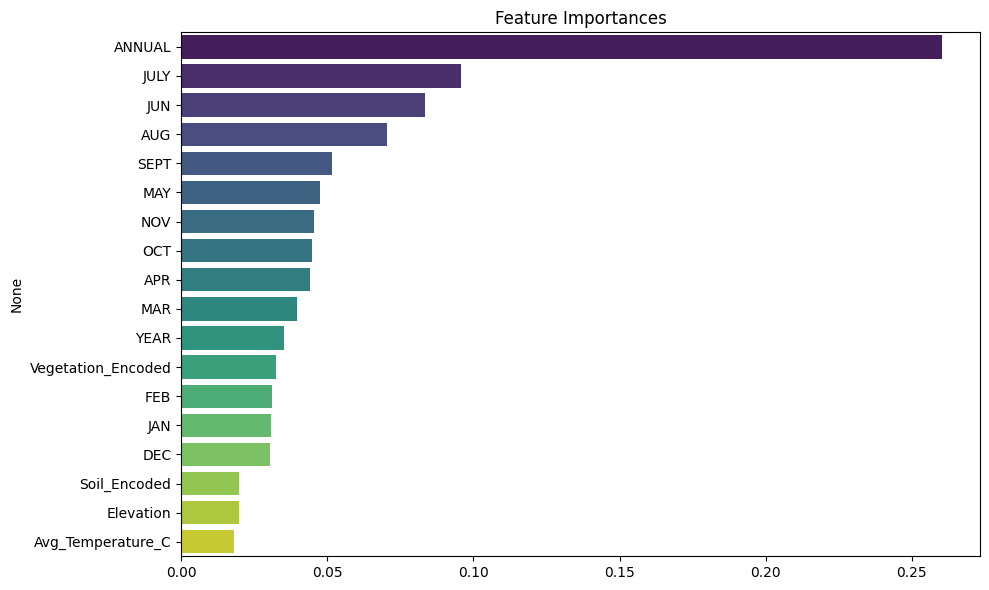

Cross-Validation Accuracy Scores: [0.75324675 0.78571429 0.74509804 0.59477124 0.87581699]
Mean CV Accuracy: 0.7509294626941686
Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best Test Accuracy After Tuning: 0.8311688311688312


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Load data
df = pd.read_csv("kerala_flood_final.csv")

# Features and Target
X = df.drop(columns=["STATE", "DISTRICT", "Soil_Type", "Vegetation Cover", "Flood_Occurred"])
y = df["Flood_Occurred"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Accuracy
train_acc = accuracy_score(y_train, rf.predict(X_train))
test_acc = accuracy_score(y_test, rf.predict(X_test))

# Confusion Matrix
cm = confusion_matrix(y_test, rf.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)

# Plot Confusion Matrix & Accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
disp.plot(ax=ax[0], cmap='Blues')
ax[0].set_title("Confusion Matrix")

sns.barplot(x=["Train Accuracy", "Test Accuracy"], y=[train_acc, test_acc], ax=ax[1])
ax[1].set_ylim(0, 1)
ax[1].bar_label(ax[1].containers[0], fmt="%.2f")
ax[1].set_title("Model Accuracy")
plt.tight_layout()
plt.show()

# Feature Importance Plot
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=X.columns[indices], palette="viridis")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

# Cross-validation score
cv_scores = cross_val_score(rf, X, y, cv=5)
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model evaluation
best_rf = grid_search.best_estimator_
best_test_acc = accuracy_score(y_test, best_rf.predict(X_test))
print("Best Parameters:", grid_search.best_params_)
print("Best Test Accuracy After Tuning:", best_test_acc)
